In [21]:
# Import Libraries

import os
import requests
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph
from dotenv import load_dotenv
from IPython.display import display, Image

In [4]:
# Load API Keys (Set these as environment variables)
load_dotenv()
GEO_API_KEY = os.getenv('GEO_API_KEY')
WEATHER_API_KEY = os.getenv('WEATHER_API_KEY')
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

### Define State for LangGraph

In [28]:
class WeatherState(TypedDict):
    query: str
    location: str
    latitude: float
    longitude: float
    weather_info: str
    final_response: str

### User-Defined Tool

In [62]:
# 1: Get Latitude & Longitude

def get_lat_long(state: WeatherState) -> WeatherState:
    """Fetch latitude and longitude using geocodes.map.co API."""
    location = state["location"]
    if location and location != 'no location':
        url = f"https://geocode.maps.co/search?q={location}&api_key={GEO_API_KEY}"
        
        response = requests.get(url).json()
        
        if len(response) > 0:
            lat = response[0]['lat']
            lon = response[0]['lon']
            return {**state, "latitude": lat, "longitude": lon}
        else:
            raise ValueError("Location not found!")
    else:
        return {**state, "latitude": 0, "longitude": 0}

In [63]:
# 2: Get Weather Information

def get_weather(state: WeatherState) -> WeatherState:
    """Fetch weather details using tomorrow.io API."""
    location = state["location"]
    if location and location != 'no location':
        lat, lon = state["latitude"], state["longitude"]
        url = f"https://api.tomorrow.io/v4/weather/realtime?location={lat},{lon}&apikey={WEATHER_API_KEY}"
    
        response = requests.get(url).json()
    
        if "data" in response and "values" in response["data"]:
            weather_info = response["data"]["values"]
            return {**state, "weather_info": str(weather_info)}
        else:
            raise ValueError("Weather data not available!")
    else:
        return {**state, "weather_info": None}

### Generate result by LLM using weather info

In [69]:
def get_location(state: WeatherState) -> WeatherState:
    """Find the location from the user query"""
    llm = ChatOpenAI(model="gpt-4o")
    prompt= f"""
    Read the user following query and return only the name of the city/state/country:
    Query: {state['query']}

    If any location is not found in user's query return 'no location'
    """
    response = llm.invoke(prompt)
    
    return {**state, "location":response.content}

In [70]:
# LLM to Generate Weather Report
def generate_weather_response(state: WeatherState) -> WeatherState:
    """Generate a weather summary using GPT-4o."""
    location = state["location"]
    if location and location != 'no location':
        llm = ChatOpenAI(model="gpt-4o")
        prompt = f"Summarize the following weather information for {state['location']}:\n\n{state['weather_info']}"
        
        response = llm.predict(prompt)
        
        return {**state, "final_response": response}
    else:
        return {**state, "final_response": "Your location is incorrect."}


### Build LangGraph Workflow

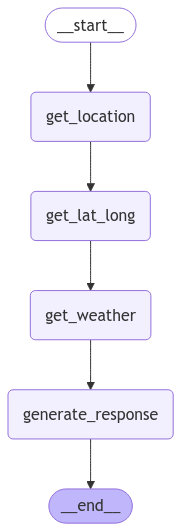

In [66]:
graph = StateGraph(WeatherState)

# Add Nodes
graph.add_node("get_location", get_location)
graph.add_node("get_lat_long", get_lat_long)
graph.add_node("get_weather", get_weather)
graph.add_node("generate_response", generate_weather_response)

# Define Workflow Order
graph.set_entry_point("get_location")
graph.add_edge("get_location", "get_lat_long")
graph.add_edge("get_lat_long", "get_weather")
graph.add_edge("get_weather", "generate_response")
graph.set_finish_point("generate_response")

# Compile Graph
weather_agent = graph.compile()

# Display workflow
display(Image(weather_agent.get_graph().draw_mermaid_png()))

In [68]:
result = weather_agent.invoke({"query": "Want to know Durgapur's weather"})
    
# Print Weather Report
print("\n🌦️ Weather Report:")
print(result["final_response"])

content='Durgapur' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 54, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'stop', 'logprobs': None} id='run-78403bf4-1fea-4bda-a961-b82b99ee23ad-0' usage_metadata={'input_tokens': 54, 'output_tokens': 4, 'total_tokens': 58, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Durgapur

🌦️ Weather Report:
The weather in Durgapur is currently clear with no cloud cover. The temperature is 17.6°C, and it feels the same at 17.6°C. The humidity level is relatively high at 81%, and the dew point is 11.1°C. There is no precipitation expected, as indicated by a 0% proba